In [5]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only consider the first two features.
y = iris.target

Text(0, 0.5, 'Sepal width')

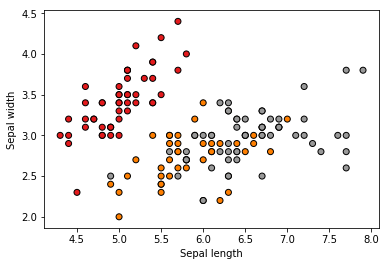

In [6]:
#Scatter plot with actual assignments
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

In [7]:
EM = GaussianMixture(n_components=3).fit(X)

In [12]:
EMpreds = EM.predict(X)

Text(0, 0.5, 'Sepal width')

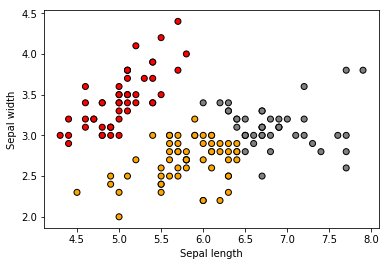

In [14]:
assignments = []
for index in EMpreds:
    if index == 0:
        assignments.append("grey")
    elif index == 1:
        assignments.append("red")
    elif index == 2:
        assignments.append("orange")
    else:
        print("Class out of bounds")
        
        
#Plot the results
plt.scatter(X[:, 0], X[:, 1], c=assignments,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

This is perhaps the nicest looking set of clusters. However, let's see how it stands against out of sample missclassification rate.

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [21]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_train)
gmix = GaussianMixture(n_components=3).fit(X_train)

kmeansPredict = kmeans.predict(X_train)
gmixPredict = gmix.predict(X_train)

print(kmeansPredict)
print(gmixPredict)
print(y_train)

[1 0 0 1 1 0 0 1 1 0 1 1 0 0 1 2 0 1 0 2 0 1 0 0 0 2 1 2 1 1 0 2 2 0 2 0 2
 2 0 0 0 0 0 2 2 0 1 0 0 0 0 0 2 1 1 2 0 1 1 2 1 0 0 1 0 2 0 1 2 2 2 2 1 1
 2 2 1 2 1 0 2 1 1 2 1 1 1 0 2 2 1 1 1 0 2 1 1 2 1 2 0 2 2 1 0 1 2 1 1 2 1
 2 0 0 0 2 2 0 2 1 0 2 0 1 2 0 0 0 1 1 1 2 0 2 1]
[1 0 0 1 1 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 2 1 2 1 1 0 0 0 2 2 0 2
 0 0 0 0 0 2 2 0 2 1 0 0 0 0 0 2 1 1 2 0 1 1 2 1 0 0 1 2 2 0 1 2 2 0 0 1 1
 0 0 0 2 1 0 2 1 1 2 1 1 1 0 0 2 1 1 1 0 0 1 1 0 1 2 0 2 0 1 0 1 2 1 1 2 1
 0 0 0 0 0 0 2 0 1 0 0 0 1 0 0 0 2 1 1 1 0 0 2 1]
[0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0 1 1 1 2 0 2 0 0 1 2 2 2 2 1 2
 1 1 2 2 2 2 1 2 1 0 2 1 1 1 1 2 0 0 2 1 0 0 1 0 2 1 0 1 2 1 0 2 2 2 2 0 0
 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0 0 1 0 2 1 2 1 0 2 0 2 0 0 2 0
 2 1 1 1 2 2 1 1 0 1 2 2 0 1 1 1 1 0 0 0 2 1 2 0]


In [22]:
from numpy.linalg import norm
from copy import deepcopy
from numpy.random import uniform
from random import randrange
import numpy as np

def loss(x,y):
    misclass = [x!=y for x,y in zip(x,y)]
    result = sum(misclass)
    return result

def newSol(x,N):
    newSol = deepcopy(x)
    randInt1 = randrange(N)
    randInt2 = randrange(N)
    for i in range(len(newSol)):
        if newSol[i]== randInt1:
            newSol[i] = randInt2
        elif newSol[i]== randInt2:
            newSol[i] = randInt1
    return newSol

In [23]:
#it's not obvious what permutation will minimize the classifications in each case.
#The best method to undertake here would be to implement a version of simulated annealing which would would 
#permute between 0,1, and 2

#Based on matlab code by Joachim Vandekerckhove
def simAnneal(x,y,N):
    #main settings
    Tinit = 1        # initial temp
    minT = 1e-8         # stopping temp
    cool = .8        # annealing schedule
    minF = float('inf')
    max_consec_rejections = 1000
    max_try = 500
    max_success = 300 #typically this is set to 20, but I had to crank it up to 200 to get consistent results
    k = 1                           # boltzmann constant

    # counters etc
    itry = 0
    success = 0
    finished = 0
    consec = 0
    T = Tinit
    parent = x
    initenergy = loss(parent,y)
    oldenergy = initenergy
    total = 0
    
    while not finished:
        itry = itry+1 # just an iteration counter
        current = parent 

        # Stop / decrement T criteria
        if itry >= max_try or success >= max_success:
            if T < minT or consec >= max_consec_rejections:
                finished = 1
                total = total + itry
                break
            else:
                T *= cool # decrease T according to cooling schedule
                total = total + itry
                itry = 1
                success = 1

        newparam = newSol(current,N)
        newenergy = loss(newparam,y)

        if (newenergy < -minF):
            parent = newparam 
            oldenergy = newenergy
            break

        if (oldenergy-newenergy > 1e-6):
            parent = newparam
            oldenergy = newenergy
            success = success+1
            consec = 0
        else:
            if (uniform() < np.exp( (oldenergy-newenergy)/(k*T) )):
                parent = newparam
                oldenergy = newenergy
                success = success+1
            else:
                consec = consec+1

    minimum = parent
    fval = oldenergy
    
    return (minimum, fval)

In [24]:
[kmeansPermuted,numMisclassified] = simAnneal(kmeansPredict,y_train,3)
print(kmeansPermuted)
print(numMisclassified/135)

[0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 2 1 0 1 2 1 0 1 1 1 2 0 2 0 0 1 2 2 1 2 1 2
 2 1 1 1 1 1 2 2 1 0 1 1 1 1 1 2 0 0 2 1 0 0 2 0 1 1 0 1 2 1 0 2 2 2 2 0 0
 2 2 0 2 0 1 2 0 0 2 0 0 0 1 2 2 0 0 0 1 2 0 0 2 0 2 1 2 2 0 1 0 2 0 0 2 0
 2 1 1 1 2 2 1 2 0 1 2 1 0 2 1 1 1 0 0 0 2 1 2 0]
0.15555555555555556


In [25]:
[gmixPermuted,numMisclassified] = simAnneal(gmixPredict,y_train,3)
print(gmixPermuted)
print(numMisclassified/135)

[0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 2 0 2 0 0 1 1 1 2 2 1 2
 1 1 1 1 1 2 2 1 2 0 1 1 1 1 1 2 0 0 2 1 0 0 2 0 1 1 0 2 2 1 0 2 2 1 1 0 0
 1 1 1 2 0 1 2 0 0 2 0 0 0 1 1 2 0 0 0 1 1 0 0 1 0 2 1 2 1 0 1 0 2 0 0 2 0
 1 1 1 1 1 1 2 1 0 1 1 1 0 1 1 1 2 0 0 0 1 1 2 0]
0.24444444444444444


Wow. It looks like EM actually has the lowest in sample error of any of the clustering techniques. But out of sample is what really matters. Let's take a look.

In [28]:
testKmeans = kmeans.predict(X_test)
testEM = EM.predict(X_test)

#Apply permutations (I just hardcoded these)

for i in range(len(X_test)):
    if testKmeans[i] == 1:
        testKmeans[i] = 0
    elif testKmeans[i] == 0:
        testKmeans[i] = 1
    if testEM[i] == 1:
        testEM[i] = 0
    elif testEM[i] == 0:
        testEM[i] = 1
        
print(loss(testKmeans,y_test))
print(loss(testKmeans,y_test)/15)
print(loss(testEM,y_test))
print(loss(testEM,y_test)/15)

6
0.4
6
0.4


Well that's pretty crazy. Looks like the misclassification rate is the same. Eventhough EM is less tuned to the dataset the Gaussian distributions generalize just as welll.

Now let's take a look at the probabability distributions.

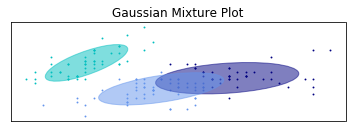

In [16]:
#code borrowed from https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py
import itertools

import numpy as np
from scipy import linalg
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    #plt.xlim(-9., 5.)
    #plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    
plot_results(X, EM.predict(X), EM.means_, EM.covariances_, 1,
             'Gaussian Mixture Plot')

We see that the Iris Setosa have a unique distribution. However, the characteristics of Iris Versicolor and Iris Virginica overlap.